# Project statement
SuperLender is a local digital lending company, which prides itself in its effective use of credit risk models to deliver profitable and high-impact loan alternative. Its assessment approach is based on two main risk drivers of loan default prediction:. 1) willingness to pay and 2) ability to pay. Since not all customers pay back, the company invests in experienced data scientist to build robust models to effectively predict the odds of repayment.

These two fundamental drivers need to be determined at the point of each application to allow the credit grantor to make a calculated decision based on repayment odds, which in turn determines if an applicant should get a loan, and if so - what the size, price and tenure of the offer will be.

There are two types of risk models in general: New business risk, which would be used to assess the risk of application(s) associated with the first loan that he/she applies. The second is a repeat or behaviour risk model, in which case the customer has been a client and applies for a repeat loan. In the latter case - we will have additional performance on how he/she repaid their prior loans, which we can incorporate into our risk model.

It is your job to predict if a loan was good or bad, i.e. accurately predict binary outcome variable, where Good is 1 and Bad is 0.

## Data
We have three datasets:
1) traindemographics.csv : This holds customer's demographic data.

2) trainperf.csv : This holds data of the repeat loan that the customer has taken for which we need to predict the performance of.  

3) trainprevloans.csv : This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of.

Further descriptions of the dataset and the data contained in them is given at the time of loading the dataset in cells ahead.

In [183]:
import pandas as pd
import warnings
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
import numpy as np
from googlemaps import Client as GoogleMaps
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
import category_encoders as ce
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
import calendar
from sklearn.preprocessing import binarize
from sklearn.svm import SVC

In [184]:
#preventing any warning messages from displaying during code execution
warnings.filterwarnings('ignore')

Next, the datasets are stored in variables in one cell and the next cell then holds the description of the data.

In [185]:
#loading traindemographics.csv into a variable called demographic
demographic = pd.read_csv('traindemographics.csv')
demographic.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


Description of demographic data:
- customerid (Primary key used to merge to other data)
- birthdate (date of birth of the customer)
- bank_account_type (type of primary bank account)
- longitude_gps
- latitude_gps
- bank_name_clients (name of the bank)
- bank_branch_clients (location of the branch - not compulsory - so missing in a lot of the cases)
- employment_status_clients (type of employment that customer has)
- level_of_education_clients (highest level of education)


In [186]:
#loading trainperf.csv into a variable called performance
performance = pd.read_csv('trainperf.csv')
performance.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


Performance data (trainperf.csv) : This is the repeat loan that the customer has taken for which we need to predict the performance of. Basically, we need to predict whether this loan would default given all previous loans and demographics of a customer.
Description of data:
- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Loan value taken)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
- termdays (Term of loan)
- referredby (customerId of the customer that referred this person - is missing, then not referred)
- good_bad_flag (good = settled loan on time; bad = did not settled loan on time) - this is the target variable that we need to predict

In [187]:
#loading trainprevloans.csv into a variable called demographic
previous = pd.read_csv('trainprevloans.csv')
previous.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


Previous loans data (trainprevloans.csv) : This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of. Each loan will have a different systemloanid, but the same customerid for each customer.
Description of data:
- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Date that loan application was created)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees) termdays (Term of loan)
- closeddate (Date that the loan was settled)
- referredby (customerId of the customer that referred this person - is missing, then not refrerred)
- firstduedate (Date of first payment due in cases where the term is longer than 30 days. So in the case where the term is 60+ days - then there are multiple monthly payments due - and this dates reflects the date of the first payment)
- firstrepaiddate (Actual date that he/she paid the first payment as defined above)

We have 3 separate datasets and the way forward would be to join the three. But we need to know if it can be a straightforward action.

In the next cell, we check to see if all customers recorded in the demographic dataset exist in the other two datasets. 

The result of the check is stored in 'customerCheck' variable.

In [188]:
customerCheck = demographic.assign(InPerformance=demographic.customerid.isin(performance.customerid), InPrevious=demographic.customerid.isin(previous.customerid))
customerCheck = customerCheck[['customerid','InPerformance','InPrevious']]

In [189]:
demographic.assign(InPerformance=demographic.customerid.isin(performance.customerid), InPrevious=demographic.customerid.isin(previous.customerid))


,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,InPerformance,InPrevious
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,True,True
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,True,True
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,True,True
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN,True,True
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4341,8a858f155554552501555588ca2b3b40,1985-12-13 00:00:00.000000,Other,3.236753,7.030168,Stanbic IBTC,NaN,Permanent,Graduate,True,True
4342,8a858fc65cf978f4015cf97cee3a02ce,1982-07-01 00:00:00.000000,Savings,7.013750,4.875662,GT Bank,NaN,NaN,NaN,True,True
4343,8a858f4f5b66de3a015b66fc83c61902,1989-09-26 00:00:00.000000,Savings,6.295530,7.092508,GT Bank,NaN,Permanent,NaN,False,False
4344,8aaae7a74400b28201441c8b62514150,1985-09-06 00:00:00.000000,Savings,3.354206,6.539070,GT Bank,HEAD OFFICE,Permanent,Primary,False,False


In [190]:
customerCheck

,customerid,InPerformance,InPrevious
0,8a858e135cb22031015cbafc76964ebd,True,True
1,8a858e275c7ea5ec015c82482d7c3996,True,True
2,8a858e5b5bd99460015bdc95cd485634,True,True
3,8a858efd5ca70688015cabd1f1e94b55,True,True
4,8a858e785acd3412015acd48f4920d04,False,False
...,...,...,...
4341,8a858f155554552501555588ca2b3b40,True,True
4342,8a858fc65cf978f4015cf97cee3a02ce,True,True
4343,8a858f4f5b66de3a015b66fc83c61902,False,False
4344,8aaae7a74400b28201441c8b62514150,False,False


From the display above of the contents of the 'customercheck' variable, we can see for each customer in the 'demographic' dataset, there are two boolean values associated with it.

The 'Inperformance' column is for the dataset performance and the 'InPrevious' column is for the dataset previous. 
'True' implies that record is in a dataset corresponding to that column and 'False' implies that is not.
For the records shown, so far we only see 'True,True' and 'False,False' pairs.
Let us confirm that with a groupby applied to the 'customercheck' dataframe.

In [191]:
customerCheck.groupby(['InPerformance','InPrevious']).value_counts()

InPerformance  InPrevious  customerid                      
False          False       8a858edd57f790040157ffe9b6ed3fbb    2
                           8a858f965bb63a25015bbf63fd062e2e    2
                           8a858fca5c35df2c015c39ad8695343e    2
                           8a858e625c8d993a015c938f829f77ee    2
                           8a28afc7474813a40147639ec637156b    1
                                                              ..
True           True        8a858e105bd92644015bd9db3a0f3be2    1
                           8a858e105bd92644015bdca43c877d2c    1
                           8a858e105bd92644015bdd2f7a981936    1
                           8a858e105bd92644015bdd374f0d1a3a    1
                           8a858fff5c79144c015c7bdbfc086ce1    1
Length: 4334, dtype: int64

From the groupby results above, we can see that in the 'customercheck' dataframe, there are only two existing pairs, 'True,True' and 'False,False'. This means there are only two possible scenarios for a customer:

1) A customer that has previously made loans(True,True)
2) A customer that has not taken out a loan before (False, False)

The records which have counts of 2 are most likely duplicates.

Next, we look at the more information about the dataframes and the data it contains

In [192]:
demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4346 entries, 0 to 4345
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  4346 non-null   object 
 1   birthdate                   4346 non-null   object 
 2   bank_account_type           4346 non-null   object 
 3   longitude_gps               4346 non-null   float64
 4   latitude_gps                4346 non-null   float64
 5   bank_name_clients           4346 non-null   object 
 6   bank_branch_clients         51 non-null     object 
 7   employment_status_clients   3698 non-null   object 
 8   level_of_education_clients  587 non-null    object 
dtypes: float64(2), object(7)
memory usage: 305.7+ KB


From the summary above of the 'demographic' dataframe, we can see that there are 4346 entries and with missing values in two of the columns:employment_status_clients and bank_branch_clients. There are only 2 numerical columns out of the 9 columns.

In [193]:
performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customerid     4368 non-null   object 
 1   systemloanid   4368 non-null   int64  
 2   loannumber     4368 non-null   int64  
 3   approveddate   4368 non-null   object 
 4   creationdate   4368 non-null   object 
 5   loanamount     4368 non-null   float64
 6   totaldue       4368 non-null   float64
 7   termdays       4368 non-null   int64  
 8   referredby     587 non-null    object 
 9   good_bad_flag  4368 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 341.4+ KB


From the summary above for the 'performance' dataframe, we can see that there are 4368 entries and only one column has missing values:referredby. There are 5 numerical columns and 5 categorical columns.

In [194]:
previous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       18183 non-null  object 
 1   systemloanid     18183 non-null  int64  
 2   loannumber       18183 non-null  int64  
 3   approveddate     18183 non-null  object 
 4   creationdate     18183 non-null  object 
 5   loanamount       18183 non-null  float64
 6   totaldue         18183 non-null  float64
 7   termdays         18183 non-null  int64  
 8   closeddate       18183 non-null  object 
 9   referredby       1026 non-null   object 
 10  firstduedate     18183 non-null  object 
 11  firstrepaiddate  18183 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 1.7+ MB


From the summary above for the 'previous' dataframe, we can see this dataframe has the most records: 18183.  Only one column has missing values: referred by.
There are five numerical columns out of the twelve columns.

From the summaries above, we saw that the 'previous' dataframe has the most entries out of all the dataframes. 
From the groupby done earlier on the customer check as well, we could see that if a customer exists in the previous dataframe, then they also exist in the performance dataframe.
If there is anything the number of entries is telling us between these two dataframes is that there is one to many relationship between these two dataframes: previous dataframe is on the many side. 

This can further be seen below when we obtain the records of customer whose id is '8a858e105bd92644015bd9db3a0f3be2' from both dataframes. The customer exists once in performance but twice in previous.

In [195]:
#records from performance dataframe of customer whose is '8a858e105bd92644015bd9db3a0f3be2'

performance.loc[performance['customerid'] == '8a858e105bd92644015bd9db3a0f3be2']

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
2899,8a858e105bd92644015bd9db3a0f3be2,301981450,3,2017-07-17 09:50:07.000000,2017-07-17 08:50:00.000000,10000.0,13000.0,30,NaN,Good


In [196]:
#records from previous dataframe of customer whose is '8a858e105bd92644015bd9db3a0f3be2'

previous.loc[previous['customerid'] == '8a858e105bd92644015bd9db3a0f3be2']

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
7765,8a858e105bd92644015bd9db3a0f3be2,301940743,2,2017-06-16 10:43:41.000000,2017-06-16 09:43:35.000000,10000.0,13000.0,30,2017-07-15 07:03:02.000000,NaN,2017-07-17 00:00:00.000000,2017-07-15 06:52:53.000000
12030,8a858e105bd92644015bd9db3a0f3be2,301911310,1,2017-05-17 13:00:00.000000,2017-05-17 11:58:51.000000,10000.0,13000.0,30,2017-06-16 10:36:38.000000,NaN,2017-06-16 00:00:00.000000,2017-06-16 10:26:29.000000


#### Checking for duplicates
We can check for duplicates in the dataframes

In [197]:
duplicate = demographic[demographic.duplicated()]
 
print("Duplicate Rows :")
 
# Print the resultant Dataframe
duplicate

Duplicate Rows :


,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
159,8a858fca5c35df2c015c39ad8695343e,1980-11-26 00:00:00.000000,Savings,3.352588,7.211089,GT Bank,NaN,Permanent,NaN
517,8a858edd57f790040157ffe9b6ed3fbb,1988-01-18 00:00:00.000000,Other,3.782563,7.171356,First Bank,NaN,Permanent,Secondary
776,8a858f965bb63a25015bbf63fd062e2e,1974-02-25 00:00:00.000000,Savings,3.936366,6.817958,Stanbic IBTC,NaN,Permanent,NaN
1015,8a858fe65675195a015679452588279c,1982-08-01 00:00:00.000000,Savings,7.533646,9.046885,UBA,NaN,Permanent,NaN
1090,8a858e6c5c88d145015c8b9627cd5a48,1979-09-30 00:00:00.000000,Savings,3.367008,6.497313,Sterling Bank,NaN,Permanent,NaN
1188,8a858fc75cd62882015cdaf2f4311b3f,1975-10-27 00:00:00.000000,Savings,7.437607,9.088935,GT Bank,NaN,Permanent,NaN
1480,8a858fe05d421ff4015d4c87d2a21ceb,1983-01-20 00:00:00.000000,Savings,8.526960,12.023015,Skye Bank,NaN,Permanent,NaN
1928,8a858e625c8d993a015c938f829f77ee,1988-12-20 00:00:00.000000,Savings,5.768333,5.561992,First Bank,NaN,Permanent,NaN
1996,8a858ec65cc6352b015cc64525ea0763,1985-01-30 00:00:00.000000,Savings,3.845728,7.411737,GT Bank,NaN,Permanent,NaN
4126,8a858f1e5baffcc9015bb02b505f180d,1983-04-06 00:00:00.000000,Savings,6.969350,4.818535,GT Bank,NaN,Permanent,NaN


In [198]:
duplicate = performance[performance.duplicated()]
 
print("Duplicate Rows :")
 
# Print the resultant Dataframe
duplicate

Duplicate Rows :


,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag


In [199]:
duplicate = previous[previous.duplicated()]
 
print("Duplicate Rows :")
 
# Print the resultant Dataframe
duplicate

Duplicate Rows :


,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate


Only duplicates in the demographic dataframe and those will be dealt with below.

In [200]:
demographic.drop_duplicates(inplace=True)

In [201]:
customerCheck = demographic.assign(InPerformance=demographic.customerid.isin(performance.customerid), InPrevious=demographic.customerid.isin(previous.customerid))
customerCheck = customerCheck[['customerid','InPerformance','InPrevious']]

In [202]:
#checking the value counts again and we can see that the earlier assumption of duplicates
#was true and now all records have only one count
customerCheck.groupby(['InPerformance','InPrevious']).value_counts()


InPerformance  InPrevious  customerid                      
False          False       8a28afc7474813a40147639ec637156b    1
                           8a3735d5518aba7301518ac34413010d    1
                           8a858f465668e3d60156790caa5f49da    1
                           8a858f3d5ab81f53015ab8334351169b    1
                           8a858f3d5add42e2015ae0d08df06d16    1
                                                              ..
True           True        8a858e0f5c45466f015c5469454d1227    1
                           8a858e0f5c45466f015c55c7e09d5e9c    1
                           8a858e105b434e9e015b437dbfab3920    1
                           8a858e105bd92644015bd9db3a0f3be2    1
                           8a858fff5c79144c015c7bdbfc086ce1    1
Length: 4334, dtype: int64

Depending on this project and its data, there is going to be a need for two models:
- the first model which would predict for non-new customers based on demographic and previous loans data.
- the second model which predict for new customers based on just demographic data.

As a group we are going to deal with and develop the first model.

### Determining how the dataframes are going to be concatenated.

#### Checking the primary key columns between the data sets along which records will be connected

##### customerid

Performance dataframe has 18183 entries and previous has 4368 entries.

In [203]:
performanceids = pd.DataFrame(performance['customerid'])
performanceids

,customerid
0,8a2a81a74ce8c05d014cfb32a0da1049
1,8a85886e54beabf90154c0a29ae757c0
2,8a8588f35438fe12015444567666018e
3,8a85890754145ace015429211b513e16
4,8a858970548359cc0154883481981866
...,...
4363,8a858e6d58b0cc520158beeb14b22a5a
4364,8a858ee85cf400f5015cf44ab1c42d5c
4365,8a858f365b2547f3015b284597147c94
4366,8a858f935ca09667015ca0ee3bc63f51


In [204]:
performanceids.groupby('customerid').value_counts().nlargest()

customerid
8a1088a0484472eb01484669e3ce4e0b    1
8a1a1e7e4f707f8b014f797718316cad    1
8a1a32fc49b632520149c3b8fdf85139    1
8a1eb5ba49a682300149c3c068b806c7    1
8a1edbf14734127f0147356fdb1b1eb2    1
dtype: int64

In [205]:
previousids = pd.DataFrame(previous['customerid'])
previousids

,customerid
0,8a2a81a74ce8c05d014cfb32a0da1049
1,8a2a81a74ce8c05d014cfb32a0da1049
2,8a2a81a74ce8c05d014cfb32a0da1049
3,8a8588f35438fe12015444567666018e
4,8a85890754145ace015429211b513e16
...,...
18178,8a858899538ddb8e0153a2b555421fc5
18179,8a858899538ddb8e0153a2b555421fc5
18180,8a858899538ddb8e0153a2b555421fc5
18181,8a858f0656b7820c0156c92ca3ba436f


In [206]:
previousids.groupby('customerid').value_counts().nlargest()

customerid
8a858f7d5578012a01557ea194d94948    26
8a858e4456ced8470156d73452f85335    22
8a85886f54517ee0015470749d3c3ce7    21
8a85888c548fb3d50154947fe59c32cf    21
8a858899538ddb8e0153a780c56e34bb    21
dtype: int64

From the analysis above, one can see that the most times a customer appears in the performance data is once, whereas the most times a customer appears in the previous data is 26 times. This confirms it is ideal to add the 'performance' dataframe to the previous dataframe.

##### adding the performance dataframe to the previous loans dataframe

Between the two dataframes,there are a number of similar columns. To add the two dataframes together, the column names of the incoming dataframe,'performance', will be changed to be able to distinguish the columns.

In [207]:
performance.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'referredby',
       'good_bad_flag'],
      dtype='object')

In [208]:
previous.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate',
       'referredby', 'firstduedate', 'firstrepaiddate'],
      dtype='object')

From the cells above, we can see the similar columns: 
customerid, systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays and referred by. 
All of these columns,apart from customerid and systemloanid, will be renamed now.
Customerid and systemloanid will not be renamed because they are going to be dropped ahead.

In [209]:
performance.columns = ['customerid','perfsystemloanid','perf_loannumber','perf_approveddate','perf_creationdate','perf_loanamount','perf_totaldue','perf_termdays','perf_referredby','good_bad_flag']

In [210]:
performance.columns

Index(['customerid', 'perfsystemloanid', 'perf_loannumber',
       'perf_approveddate', 'perf_creationdate', 'perf_loanamount',
       'perf_totaldue', 'perf_termdays', 'perf_referredby', 'good_bad_flag'],
      dtype='object')

In [211]:
previous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       18183 non-null  object 
 1   systemloanid     18183 non-null  int64  
 2   loannumber       18183 non-null  int64  
 3   approveddate     18183 non-null  object 
 4   creationdate     18183 non-null  object 
 5   loanamount       18183 non-null  float64
 6   totaldue         18183 non-null  float64
 7   termdays         18183 non-null  int64  
 8   closeddate       18183 non-null  object 
 9   referredby       1026 non-null   object 
 10  firstduedate     18183 non-null  object 
 11  firstrepaiddate  18183 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 1.7+ MB


In [212]:
#joining previous and performance dataframes in a dataframe called 'previousCustomers'
previousCustomers = pd.merge(previous, performance, on='customerid')

In [213]:
previousCustomers

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,...,firstrepaiddate,perfsystemloanid,perf_loannumber,perf_approveddate,perf_creationdate,perf_loanamount,perf_totaldue,perf_termdays,perf_referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,...,2016-09-01 15:51:43.000000,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,...,2017-05-26 00:00:00.000000,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,...,2017-04-26 22:03:47.000000,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
3,8a2a81a74ce8c05d014cfb32a0da1049,301923941,10,2017-06-01 13:34:30.000000,2017-06-01 12:34:21.000000,20000.0,24500.0,30,2017-06-25 15:24:06.000000,NaN,...,2017-06-25 15:13:56.000000,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
4,8a2a81a74ce8c05d014cfb32a0da1049,301954468,11,2017-06-28 10:58:34.000000,2017-06-28 09:58:25.000000,20000.0,24500.0,30,2017-07-25 08:14:36.000000,NaN,...,2017-07-25 08:04:27.000000,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18178,8a858f305c8dd672015c92b0711a3333,301941335,1,2017-06-16 18:16:37.000000,2017-06-16 17:15:29.000000,10000.0,11500.0,15,2017-06-26 14:02:03.000000,NaN,...,2017-06-26 13:51:54.000000,301978946,2,2017-07-15 10:42:38.000000,2017-07-15 09:42:24.000000,10000.0,11500.0,15,NaN,Good
18179,8a858fe7568ed7420156920bff565cc7,301955570,1,2017-06-29 01:25:57.000000,2017-06-29 00:25:48.000000,10000.0,11500.0,15,2017-07-05 14:31:17.000000,NaN,...,2017-07-05 14:21:08.000000,301976025,2,2017-07-13 13:07:40.000000,2017-07-13 12:07:32.000000,10000.0,13000.0,30,NaN,Good
18180,8a858f6459b6456d0159b69978f22bed,301796830,1,2017-01-19 14:00:16.000000,2017-01-19 13:00:02.000000,10000.0,11500.0,15,2017-02-15 09:06:34.000000,NaN,...,2017-02-15 08:51:25.000000,301969032,2,2017-07-08 10:12:52.000000,2017-07-08 09:12:37.000000,10000.0,13000.0,30,NaN,Good
18181,8a858fad5ccb633e015ccbe337372ab3,301946936,1,2017-06-21 20:19:29.000000,2017-06-21 19:18:21.000000,10000.0,13000.0,30,2017-07-07 17:08:47.000000,8a858eaa55a0b8ae0155ad2cab5e49cc,...,2017-07-07 16:58:38.000000,301977456,2,2017-07-14 12:00:54.000000,2017-07-14 11:00:48.000000,10000.0,13000.0,30,8a858eaa55a0b8ae0155ad2cab5e49cc,Good


In [214]:
previousCustomers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18183 entries, 0 to 18182
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerid         18183 non-null  object 
 1   systemloanid       18183 non-null  int64  
 2   loannumber         18183 non-null  int64  
 3   approveddate       18183 non-null  object 
 4   creationdate       18183 non-null  object 
 5   loanamount         18183 non-null  float64
 6   totaldue           18183 non-null  float64
 7   termdays           18183 non-null  int64  
 8   closeddate         18183 non-null  object 
 9   referredby         1026 non-null   object 
 10  firstduedate       18183 non-null  object 
 11  firstrepaiddate    18183 non-null  object 
 12  perfsystemloanid   18183 non-null  int64  
 13  perf_loannumber    18183 non-null  int64  
 14  perf_approveddate  18183 non-null  object 
 15  perf_creationdate  18183 non-null  object 
 16  perf_loanamount    181

Dropping the systemloanid columns as these are just transaction identifiers

In [215]:
previousCustomers.drop(['systemloanid','perfsystemloanid'],axis=1,inplace=True)
previousCustomers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18183 entries, 0 to 18182
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerid         18183 non-null  object 
 1   loannumber         18183 non-null  int64  
 2   approveddate       18183 non-null  object 
 3   creationdate       18183 non-null  object 
 4   loanamount         18183 non-null  float64
 5   totaldue           18183 non-null  float64
 6   termdays           18183 non-null  int64  
 7   closeddate         18183 non-null  object 
 8   referredby         1026 non-null   object 
 9   firstduedate       18183 non-null  object 
 10  firstrepaiddate    18183 non-null  object 
 11  perf_loannumber    18183 non-null  int64  
 12  perf_approveddate  18183 non-null  object 
 13  perf_creationdate  18183 non-null  object 
 14  perf_loanamount    18183 non-null  float64
 15  perf_totaldue      18183 non-null  float64
 16  perf_termdays      181

In [216]:
#adding the demographic data to the previousCustomers dataframe
previousCustomers = pd.merge(previousCustomers, demographic, on='customerid')

In [217]:
previousCustomers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13673 entries, 0 to 13672
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  13673 non-null  object 
 1   loannumber                  13673 non-null  int64  
 2   approveddate                13673 non-null  object 
 3   creationdate                13673 non-null  object 
 4   loanamount                  13673 non-null  float64
 5   totaldue                    13673 non-null  float64
 6   termdays                    13673 non-null  int64  
 7   closeddate                  13673 non-null  object 
 8   referredby                  800 non-null    object 
 9   firstduedate                13673 non-null  object 
 10  firstrepaiddate             13673 non-null  object 
 11  perf_loannumber             13673 non-null  int64  
 12  perf_approveddate           13673 non-null  object 
 13  perf_creationdate           136

##### looking at the data contained in the columns now to determine what columns will be used to train the model

*columns containing non-numerical data*

In [218]:
categorical = [var for var in previousCustomers.columns if previousCustomers[var].dtype=='O']

print('There are {} categorical variables \n'.format(len(categorical)))

print('They are: ', categorical)

There are 17 categorical variables 

They are:  ['customerid', 'approveddate', 'creationdate', 'closeddate', 'referredby', 'firstduedate', 'firstrepaiddate', 'perf_approveddate', 'perf_creationdate', 'perf_referredby', 'good_bad_flag', 'birthdate', 'bank_account_type', 'bank_name_clients', 'bank_branch_clients', 'employment_status_clients', 'level_of_education_clients']


In [219]:
previousCustomers[categorical].head()

,customerid,approveddate,creationdate,closeddate,referredby,firstduedate,firstrepaiddate,perf_approveddate,perf_creationdate,perf_referredby,good_bad_flag,birthdate,bank_account_type,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,NaN,Good,1972-01-15 00:00:00.000000,Other,Diamond Bank,NaN,Permanent,Post-Graduate
1,8a2a81a74ce8c05d014cfb32a0da1049,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,NaN,Good,1972-01-15 00:00:00.000000,Other,Diamond Bank,NaN,Permanent,Post-Graduate
2,8a2a81a74ce8c05d014cfb32a0da1049,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,NaN,Good,1972-01-15 00:00:00.000000,Other,Diamond Bank,NaN,Permanent,Post-Graduate
3,8a2a81a74ce8c05d014cfb32a0da1049,2017-06-01 13:34:30.000000,2017-06-01 12:34:21.000000,2017-06-25 15:24:06.000000,NaN,2017-07-03 00:00:00.000000,2017-06-25 15:13:56.000000,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,NaN,Good,1972-01-15 00:00:00.000000,Other,Diamond Bank,NaN,Permanent,Post-Graduate
4,8a2a81a74ce8c05d014cfb32a0da1049,2017-06-28 10:58:34.000000,2017-06-28 09:58:25.000000,2017-07-25 08:14:36.000000,NaN,2017-07-31 00:00:00.000000,2017-07-25 08:04:27.000000,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,NaN,Good,1972-01-15 00:00:00.000000,Other,Diamond Bank,NaN,Permanent,Post-Graduate


##### customer id column: Primary key used to merge to other data

In [220]:
len(previousCustomers['customerid'].unique())

3264

customer id column has a high cardinality and is used to uniquely identify the customers. This feature will not be used for model training.

##### approved date column : Date that loan was approved

In [221]:
len(previousCustomers['approveddate'].unique())

13666

approved date column has a high cardinality. It will not be used because we don't believe the approval data for a loan holds a significance towards whether a loan may be bad or good.

##### creation date column : Date that loan application was created

In [222]:
len(previousCustomers['creationdate'].unique())

13666

creation date column has a high cardinality. It will not be selected as feature to train the model because we do not believe the creation date for a loan holds a significance towards whether a loan may be bad or good

##### closed date column : Date that the loan was settled

closed date column has a high cardinality. Since we have a loan creation date, we can arrive at how long the loan was active until it was settled. This time period can then be used as a new feature to train the model. Let's look more at the closed dates and see if there is a relationship  between the closing dates and good/bad loans.

In [223]:
#extracting the closed date of customer's loans
closedDates = previousCustomers[['closeddate','good_bad_flag']]
closedDates

,closeddate,good_bad_flag
0,2016-09-01 16:06:48.000000,Good
1,2017-05-28 14:44:49.000000,Good
2,2017-04-26 22:18:56.000000,Good
3,2017-06-25 15:24:06.000000,Good
4,2017-07-25 08:14:36.000000,Good
...,...,...
13668,2017-07-18 16:33:55.000000,Good
13669,2017-07-11 14:26:40.000000,Good
13670,2017-06-26 14:02:03.000000,Good
13671,2017-07-05 14:31:17.000000,Good


 going to break down the date and individual components, ie year, month and day and time. Then proceed to gain insights into the relationship between date/time and bad/good loans

In [224]:
#converting 'closeddate' columns into datetime object
closedDates['closeddate'] = pd.to_datetime(closedDates['closeddate'])

In [225]:
#checking to see the closeddate column datatype
closedDates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13673 entries, 0 to 13672
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   closeddate     13673 non-null  datetime64[ns]
 1   good_bad_flag  13673 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 320.5+ KB


In [226]:
#extracting the year from closeddate column
closedDates['year'] = closedDates['closeddate'].dt.year
closedDates.head()

,closeddate,good_bad_flag,year
0,2016-09-01 16:06:48,Good,2016
1,2017-05-28 14:44:49,Good,2017
2,2017-04-26 22:18:56,Good,2017
3,2017-06-25 15:24:06,Good,2017
4,2017-07-25 08:14:36,Good,2017


In [227]:
#extracting the month from closeddate column
closedDates['month'] = closedDates['closeddate'].dt.month
closedDates.head()

,closeddate,good_bad_flag,year,month
0,2016-09-01 16:06:48,Good,2016,9
1,2017-05-28 14:44:49,Good,2017,5
2,2017-04-26 22:18:56,Good,2017,4
3,2017-06-25 15:24:06,Good,2017,6
4,2017-07-25 08:14:36,Good,2017,7


In [228]:
#extracting the day from closeddate column
closedDates['day'] = closedDates['closeddate'].dt.day
closedDates.head()

,closeddate,good_bad_flag,year,month,day
0,2016-09-01 16:06:48,Good,2016,9,1
1,2017-05-28 14:44:49,Good,2017,5,28
2,2017-04-26 22:18:56,Good,2017,4,26
3,2017-06-25 15:24:06,Good,2017,6,25
4,2017-07-25 08:14:36,Good,2017,7,25


In [229]:
#extracting the hour from closeddate column
closedDates['hourOfDay'] = closedDates['closeddate'].dt.hour
closedDates.head()

,closeddate,good_bad_flag,year,month,day,hourOfDay
0,2016-09-01 16:06:48,Good,2016,9,1,16
1,2017-05-28 14:44:49,Good,2017,5,28,14
2,2017-04-26 22:18:56,Good,2017,4,26,22
3,2017-06-25 15:24:06,Good,2017,6,25,15
4,2017-07-25 08:14:36,Good,2017,7,25,8


In [230]:
#checking to see if the hours are in 12-hour or 24-hour format
closedDates['hourOfDay'].unique()

array([16, 14, 22, 15,  8, 13, 18, 11,  1,  4,  0, 10, 17, 21, 23,  9, 20,
       12,  5,  6, 19,  7,  3,  2])

the hour is recorded in 24 hour clock which is desirable so we can differentiate between the times i.e 3 in the morning and 3 in the evening.

In [231]:
closedDates['year'].unique()

array([2016, 2017])

This dataset contains records for only the years 2016 and 2017.

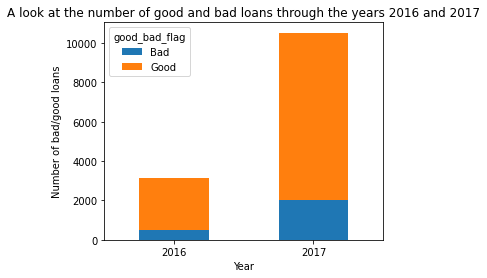

In [232]:
#plotting a stacked bar graph to show the loans(good and bad) in the years 2016 and 2017

closedDates.groupby(['year','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True,rot=0)
plt.xlabel('Year')
plt.ylabel('Number of bad/good loans')

plt.title('A look at the number of good and bad loans through the years 2016 and 2017')

#getting current figure instance and setting width
f = plt.gcf()
f.set_figwidth(5) 

From the graph above, we can see that the number of bad loans increased from 2016 to 2017 as well as the overall number of loans being taken out

From this graph as well we can notice that our data is imbalance with the good loans outnumbering the bad loans by a large margin. This will be dealt on ahead in the notebook.

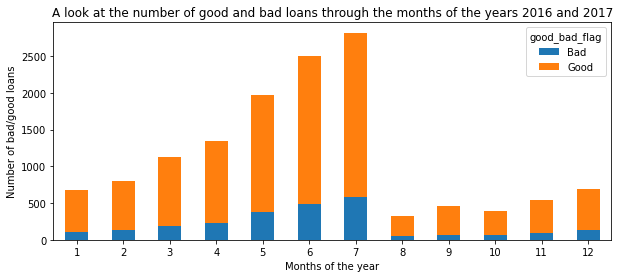

In [233]:
closedDates.groupby(['month','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True,rot=0)
plt.xlabel('Months of the year')
plt.ylabel('Number of bad/good loans')
plt.title('A look at the number of good and bad loans through the months of the years 2016 and 2017')

f = plt.gcf()
f.set_figwidth(10) 

From the graph above, we can see that for both the years 2016 and 2017, there was a high number of loans, good and bad in July and then the least number in the subsequent month of August 

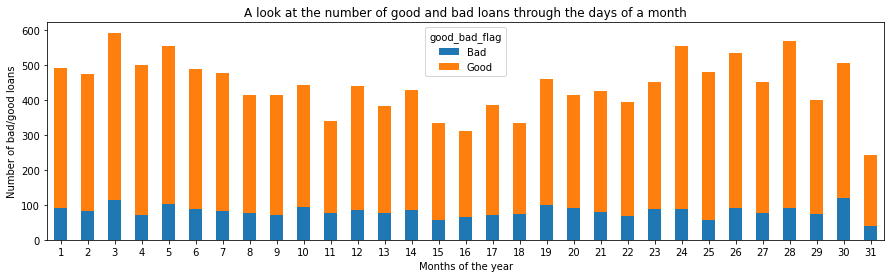

In [234]:
closedDates.groupby(['day','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True,rot=0)
plt.xlabel('Months of the year')
plt.ylabel('Number of bad/good loans')
plt.title('A look at the number of good and bad loans through the days of a month')

f = plt.gcf()
f.set_figwidth(15) 

From the graph above, we can see there is not much to the type of loans according to the period in the month: beginning, end or middle

<Figure size 1080x2160 with 0 Axes>

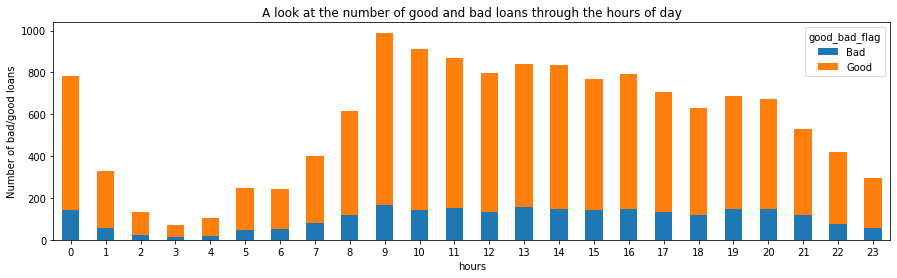

In [235]:
plt.figure(figsize=(15,30))
closedDates.groupby(['hourOfDay','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True,rot=0)
plt.xlabel('hours')
plt.ylabel('Number of bad/good loans')

plt.title('A look at the number of good and bad loans through the hours of day')

f = plt.gcf()
f.set_figwidth(15) 

From the graph above, we can see that there is not much activity between the hours of 1 and 6 since people are sleeping and for the rest of the day, nothing much significant in the loan activity.

We do not think that the year serves as a significant feature to train this model and therefore it will not be used going forward. The months, day and hour of the day also do not serve as good features to use to train this model.

In [236]:
previousCustomers.head()

,customerid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,...,perf_referredby,good_bad_flag,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,...,NaN,Good,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate
1,8a2a81a74ce8c05d014cfb32a0da1049,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,...,NaN,Good,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate
2,8a2a81a74ce8c05d014cfb32a0da1049,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,...,NaN,Good,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate
3,8a2a81a74ce8c05d014cfb32a0da1049,10,2017-06-01 13:34:30.000000,2017-06-01 12:34:21.000000,20000.0,24500.0,30,2017-06-25 15:24:06.000000,NaN,2017-07-03 00:00:00.000000,...,NaN,Good,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate
4,8a2a81a74ce8c05d014cfb32a0da1049,11,2017-06-28 10:58:34.000000,2017-06-28 09:58:25.000000,20000.0,24500.0,30,2017-07-25 08:14:36.000000,NaN,2017-07-31 00:00:00.000000,...,NaN,Good,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate


We can instead obtain the duration of the lifetime of the loan i.e from when it was created to when it was fully paid back. 

In [237]:
previousCustomers['closeddate'] = pd.to_datetime(previousCustomers['closeddate'])
previousCustomers['creationdate'] = pd.to_datetime(previousCustomers['creationdate'])

In [238]:
#the difference between the closedDate and the creationDate is stored in a new column
# called 'loanlife'. The difference between the two columns is divided by a delta object 
# so we can get the difference in days
previousCustomers['loanlife'] = ((previousCustomers.closeddate - previousCustomers.creationdate)/np.timedelta64(1, 'D'))
previousCustomers.head()

,customerid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,...,good_bad_flag,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,loanlife
0,8a2a81a74ce8c05d014cfb32a0da1049,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32,10000.0,13000.0,30,2016-09-01 16:06:48,NaN,2016-09-14 00:00:00.000000,...,Good,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate,16.947407
1,8a2a81a74ce8c05d014cfb32a0da1049,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53,10000.0,13000.0,30,2017-05-28 14:44:49,NaN,2017-05-30 00:00:00.000000,...,Good,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate,29.879120
2,8a2a81a74ce8c05d014cfb32a0da1049,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19,20000.0,23800.0,30,2017-04-26 22:18:56,NaN,2017-04-04 00:00:00.000000,...,Good,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate,52.515706
3,8a2a81a74ce8c05d014cfb32a0da1049,10,2017-06-01 13:34:30.000000,2017-06-01 12:34:21,20000.0,24500.0,30,2017-06-25 15:24:06,NaN,2017-07-03 00:00:00.000000,...,Good,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate,24.117882
4,8a2a81a74ce8c05d014cfb32a0da1049,11,2017-06-28 10:58:34.000000,2017-06-28 09:58:25,20000.0,24500.0,30,2017-07-25 08:14:36,NaN,2017-07-31 00:00:00.000000,...,Good,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate,26.927905


We will use the loanlife column as a new feature to train our model with.

We are going to list out the columns that have been selected to train our model to keep track of them as the notebook progresses:
1. period take to settle the loan(lifetime of loan)

##### referredby column

In [239]:
previousCustomers['referredby'].isnull().sum()

12873

In [240]:
len(previousCustomers['referredby'].unique())

408

In [241]:
previousCustomers['referredby'].unique()

array([nan, '8a858ff85bd93919015bda56605652bd',
       '8a858edc59ee87640159eeb9774f1aa7',
       '8a858fc55b2548dd015b286e452c678c',
       '8a858eba5c884d2a015c8bea59385157',
       '8a858e185b4923b4015b536354895cae',
       '8a858fd85b685607015b7ba5638674c0',
       '8a858f9f5bd99987015be3f53cb442d9',
       '8a858fee5800e000015805aae2fe4ef8',
       '8a858fdc57ab280a0157b277e9ff6d53',
       '8a858e645755e62201575e72c8b77fd5',
       '8a858edb5ad79cc6015ad7c9b29415c8',
       '8a858f975c4582c4015c54619e9b7e2b',
       '8a858e6f5bce1023015bce19dbbf038d',
       '8a858f1b5b9136f7015b9f66e5c5327c',
       '8a858e7855113fb701551fe018ce6913',
       '8a858fa3551e78cb01552596fed60cec',
       '8a858eda5c8863ff015c8b96e5fd74d0',
       '8a858ed75732b681015744c9dee21aae',
       '8a858f1e5aec5791015aef876abb0dbc',
       '8a858fa75b5c94ed015b5c9d50890bb4',
       '8a8589ac53a917ed0153a9f9e614244b',
       '8a858f475c7ea023015c81ad999a0386',
       '8a858e5b5bd99460015bd9e9ee2e18f4',
      

The referredby column has a high cardinality. The details of the referee may have been useful though but due to the large number of missing values that cannot easily be imputed, the column value cannot particularly give any relevance to the model. This feature will not be used.

##### first_due_date and first_repaid_date columns

This columns individually don't provide significant features but when used together might prove to be more useful.
The difference between the two columns can tell us if a customer was prompt on making their payments.

In [242]:
#isolating the firstduedate, firstrepaiddate and good_bad_flag into a dataframe of its own
loanrepayment = previousCustomers[['firstduedate','firstrepaiddate','good_bad_flag']]

In [243]:
loanrepayment.head()

,firstduedate,firstrepaiddate,good_bad_flag
0,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000,Good
1,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000,Good
2,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000,Good
3,2017-07-03 00:00:00.000000,2017-06-25 15:13:56.000000,Good
4,2017-07-31 00:00:00.000000,2017-07-25 08:04:27.000000,Good


In [244]:
loanrepayment['firstduedate'] = pd.to_datetime(loanrepayment['firstduedate'])
loanrepayment['firstrepaiddate'] = pd.to_datetime(loanrepayment['firstrepaiddate'])

In [245]:
# the difference between the closedDate and the creationDate is stored in a new column
# called 'firstrepaymentlapse'
loanrepayment['firstrepaymentlapse'] = ((loanrepayment.firstduedate - loanrepayment.firstrepaiddate)/np.timedelta64(1, 'D'))
loanrepayment.head()

,firstduedate,firstrepaiddate,good_bad_flag,firstrepaymentlapse
0,2016-09-14,2016-09-01 15:51:43,Good,12.339086
1,2017-05-30,2017-05-26 00:00:00,Good,4.000000
2,2017-04-04,2017-04-26 22:03:47,Good,-22.919294
3,2017-07-03,2017-06-25 15:13:56,Good,7.365324
4,2017-07-31,2017-07-25 08:04:27,Good,5.663576


For the column 'firstrepaymentlapse', the positive values indicate someone who was able to pay before the due date and negative values are someone who paid after the due date

Updating selected features:
1. period take to settle the loan(lifetime of loan)
2. first repayment day status: loanrepayment

The next cells are looking at the data from the performance dataframe. Those columns that were also present in the previous dataframe and were dropped as features above, will also be dropped as features below. 

##### perf_referredby

In [246]:
len(previousCustomers['perf_referredby'].unique())

408

In [247]:
previousCustomers['perf_referredby'].isnull().sum()

12873

There are a number of null values within this columns and we cannot easily replace the missing values. This column will therefore not be used going forward

##### birthdate

This column may not be significant as it is for training our model. It may be better to get the actual age of the customers rather than using there birthdates.

So let us get the actual ages of the customers.

In [248]:
#converting birthdate column to datetime
previousCustomers['birthdate'] = pd.to_datetime(previousCustomers['birthdate'])

In [249]:
customerAge = previousCustomers[['birthdate','good_bad_flag']]
customerAge.head()

,birthdate,good_bad_flag
0,1972-01-15,Good
1,1972-01-15,Good
2,1972-01-15,Good
3,1972-01-15,Good
4,1972-01-15,Good


In [250]:
currentDate = date.today()

In [251]:
currentDate

datetime.date(2022, 12, 12)

In [252]:
customerAge['age'] = round(((pd.datetime.now()- customerAge['birthdate'])/np.timedelta64(1, 'Y')),1)

In [253]:
customerAge.tail()

,birthdate,good_bad_flag,age
13668,1986-02-20,Good,36.8
13669,1979-04-18,Good,43.7
13670,1989-11-19,Good,33.1
13671,1980-11-12,Good,42.1
13672,1989-10-24,Good,33.1


###### for the next graph, it was generated in Microsoft Excel. A pivot table was used to group the ages and get the number of bad loans in each age group, it was then displayed in the people graph. The files being saved were exported to excel

In [254]:
customerAge.to_csv('allLoansAndAges.csv')

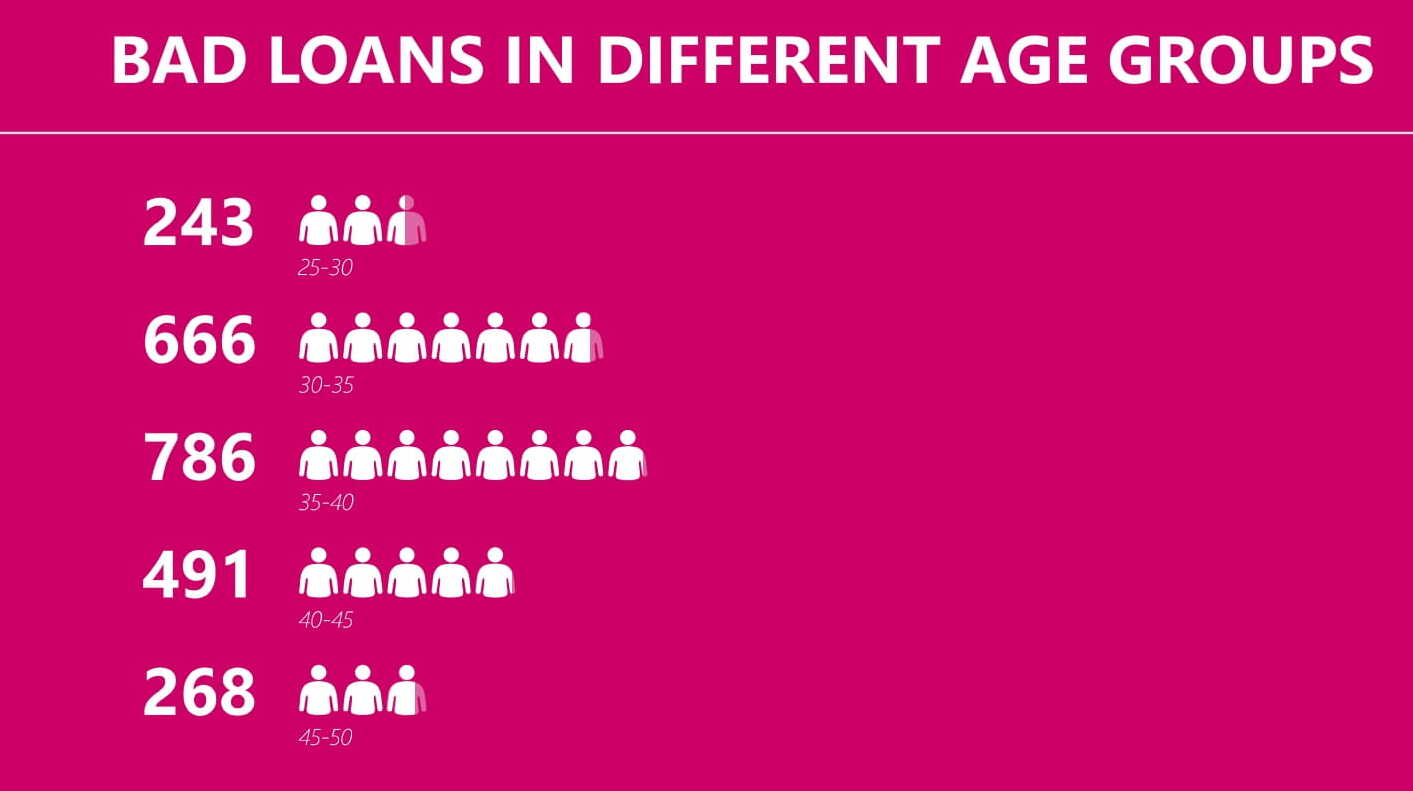

so we shall use the ages of people to train our model instead of their birthdate

Updating selected features:
1. period take to settle the loan(lifetime of loan)
2. first repayment day status: loanrepayment
3. ages of the customers

##### bank account type: type of primary bank account

In [255]:
len(previousCustomers['bank_account_type'].unique())

3

In [256]:
testdemo = pd.read_csv('testdemographics.csv')

In [257]:
len(testdemo['bank_account_type'].unique())

3

In [258]:
previousCustomers['bank_account_type'].isnull().sum()

0

In [259]:
previousCustomers['bank_account_type'].unique()

array(['Other', 'Savings', 'Current'], dtype=object)

This feature shall be used to train our model

Updating selected features:
1. period take to settle the loan(lifetime of loan): previousCustomers
2. first repayment day status: loanrepayment
3. ages of the customers
4. the type of bank account

##### bank_name_clients: name of the bank

In [260]:
previousCustomers['bank_name_clients'].unique()

array(['Diamond Bank', 'EcoBank', 'First Bank', 'GT Bank', 'UBA',
       'Union Bank', 'FCMB', 'Access Bank', 'Zenith Bank',
       'Fidelity Bank', 'Stanbic IBTC', 'Skye Bank', 'Sterling Bank',
       'Wema Bank', 'Keystone Bank', 'Unity Bank', 'Heritage Bank',
       'Standard Chartered'], dtype=object)

In [261]:
len(previousCustomers['bank_name_clients'].unique())

18

In [262]:
previousCustomers['bank_name_clients'].isnull().sum()

0

In [263]:
len(testdemo['bank_name_clients'].unique())

18

This column will be used to train the model

Updating selected features:
1. period take to settle the loan(lifetime of loan)
2. first repayment day status:
3. ages of the customers
4. the type of bank account
5. the bank name of the clients

We can also have a look the bad loans and good loans according to the different banks

In [264]:
bankStats = previousCustomers[['bank_name_clients','good_bad_flag']]

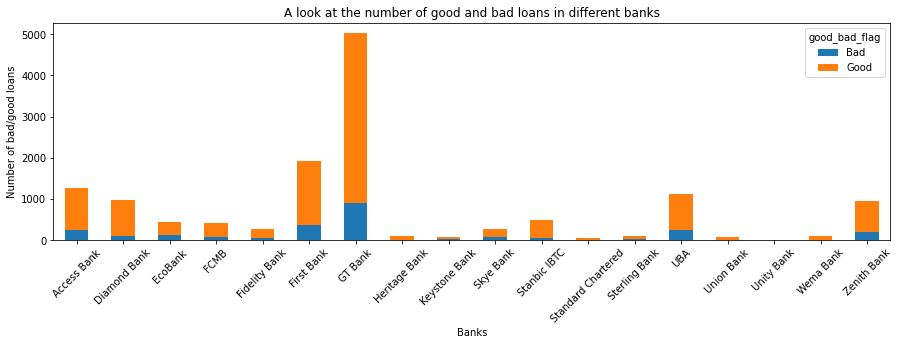

In [265]:
bankStats.groupby(['bank_name_clients','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True,rot=45)
plt.xlabel('Banks')
plt.ylabel('Number of bad/good loans')

plt.title('A look at the number of good and bad loans in different banks')

f = plt.gcf()
f.set_figwidth(15) 

From the graph above, we can see that the highest number of loans, and subsequently the highest number of bad loans, taken out has been from GT bank. 

In [266]:
# FIND THE AGE RANGE OF THE PEOPLE WHO ARE GOING TO THE DIFFERENT BANKS,
#use pivot table and see the most common bank in the 
#age range and see if there's a connection

##### bank branch clients

In [267]:
previousCustomers['bank_branch_clients'].unique()

array([nan, 'OBA ADEBIMPE', 'RING ROAD', 'AKUTE', 'OGBA',
       'ADEOLA HOPEWELL', 'ABEOKUTA', 'OJUELEGBA', 'LAGOS',
       'OBA AKRAN BERGER PAINT',
       'ACCESS BANK PLC, CHALLENGE ROUNDABOUT IBADAN, OYO STATE.',
       'BOSSO ROAD, MINNA',
       'PLOT 999C DANMOLE STREET, ADEOLA ODEKU, VICTORIA ISLAND, LAGOS',
       'MAFOLUKU', '17, SANUSI FAFUNWA STREET, VICTORIA ISLAND, LAGOS',
       'TRANS AMADI', 'APAPA', 'MUSHIN BRANCH', 'OAU ILE IFE',
       ' IDI - ORO MUSHIN', 'AJOSE ADEOGUN', 'TINCAN', 'ABULE EGBA',
       'OBA AKRAN', 'STERLING BANK PLC 102, IJU ROAD, IFAKO BRANCH',
       'LEKKI EPE', 'OGUDU, OJOTA', 'AKURE BRANCH',
       '40,SAPELE ROAD ,OPPOSITE DUMAZ JUNCTION BENIN CITY EDO STATE.'],
      dtype=object)

In [268]:
previousCustomers['bank_branch_clients'].isnull().sum()

13569

This column will not be used to train our model due to the large number of missing values that cannot easily be replaced.

##### employment status clients

In [269]:
previousCustomers['employment_status_clients'].unique()

array(['Permanent', nan, 'Self-Employed', 'Student', 'Unemployed',
       'Retired', 'Contract'], dtype=object)

In [270]:
#loading the testdemographics dataset to see if the values in the previous cell
#are also the values in the test dataset
testdemo = pd.read_csv('testdemographics.csv')

In [271]:
testdemo['employment_status_clients'].unique()

array(['Permanent', 'Self-Employed', nan, 'Student', 'Contract',
       'Unemployed', 'Retired'], dtype=object)

In [272]:
previousCustomers['employment_status_clients'].isnull().sum()

1363

In [273]:
#imputing the missing values with 'Not given'
previousCustomers['employment_status_clients'].fillna("Employment_not-given", inplace=True)

Updating selected features:
1. closed date month: closedDates[month]
2. closed date day: closedDates[day]
3. closed date hour of day: closedDates[hourOfDay]
4. period take to settle the loan(lifetime of loan): previousCustomers[loanlifewithdelta]
5. first repayment day status: loanrepayment[firstrepaymentlapsewithdelta]
6. ages of the customers: birthdate[age]
7. the type of bank account: previousCustomers[bank_account_type]
8. the bank name of the clients: previousCustomers[bank_name_clients]
9. the employment status of clients: previousCustomers[employment_status]

We can also see how the number of bad and good loans relates to a person's employment status

In [274]:
jobstatus = previousCustomers[['employment_status_clients','good_bad_flag']]

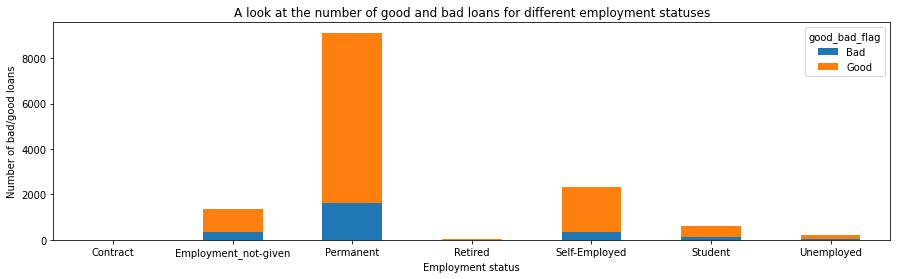

In [275]:
jobstatus.groupby(['employment_status_clients','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True,rot=0)
plt.xlabel('Employment status')
plt.ylabel('Number of bad/good loans')

plt.title('A look at the number of good and bad loans for different employment statuses')

#plt.subplot(4,1,2)
#plt.title('A look at the number of good and bad loans throughout the years')

f = plt.gcf()
f.set_figwidth(15) 

From the graph above, we can see that people of 'Permanent' employment type take out the most loans. They also have the most bad loans as compared to other employment statuses.

##### level of education of clients

In [276]:
previousCustomers['level_of_education_clients'].unique()

array(['Post-Graduate', nan, 'Primary', 'Graduate', 'Secondary'],
      dtype=object)

In [277]:
previousCustomers['level_of_education_clients'].isnull().sum()

10209

There is a high number of missing values but this column can be a good feature to train our model on. The missing values will therefore be imputed with 'Not-given'

In [278]:
previousCustomers['level_of_education_clients'].fillna('Education_not-given', inplace=True)

Updating selected features:
1. closed date month: closedDates[month]
2. closed date day: closedDates[day]
3. closed date hour of day: closedDates[hourOfDay]
4. period take to settle the loan(lifetime of loan): previousCustomers[loanlifewithdelta]
5. first repayment day status: loanrepayment[firstrepaymentlapsewithdelta]
6. ages of the customers: birthdate[age]
7. the type of bank account: previousCustomers[bank_account_type]
8. the bank name of the clients: previousCustomers[bank_name_clients]
9. the employment status of clients: previousCustomers[employment_status]
10. the level of education of clients: previousCustomers[level_of_education_clients]

We can still look at the how the level of education plays out in the matter of bad and good loans

In [279]:
educationlevel = previousCustomers[['level_of_education_clients','good_bad_flag']]

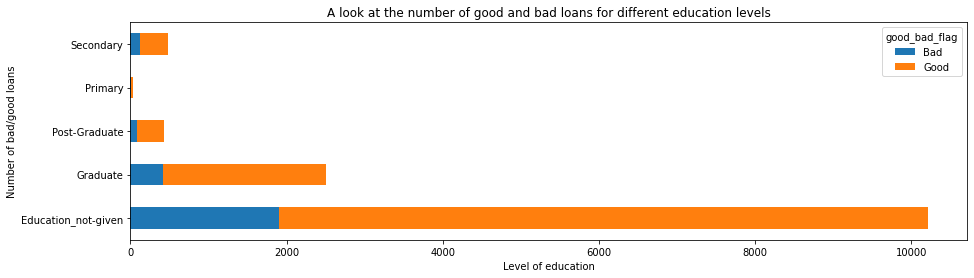

In [280]:

#plt.subplot(4,1,1)
#yearLook = closedDates[['year', 'good_bad_flag']]
educationlevel.groupby(['level_of_education_clients','good_bad_flag']).size().unstack().plot(kind='barh',stacked=True,rot=0)
plt.xlabel('Level of education')
plt.ylabel('Number of bad/good loans')

plt.title('A look at the number of good and bad loans for different education levels')

#plt.subplot(4,1,2)
#plt.title('A look at the number of good and bad loans throughout the years')

f = plt.gcf()
f.set_figwidth(15) 

We can see that the people whose education level we don't know take out the highest number of loans and also have the highest number of bad loans. This is then followed by the graduate education level.

So we have gone through the non-numerical features of our data and have selected the following 6 columns as features to train our model with:
1. period take to settle the loan(lifetime of loan)
2. first repayment day status
3. ages of the customers
4. the type of bank account: 
5. the bank name of the clients
6. the level of education of clients: 

#### Now to look at the numerical columns

In [281]:
numerical = [var for var in previousCustomers.columns if previousCustomers[var].dtype!='O']

print('There are {} numerical variabes \n'.format(len(numerical)))

print('They are: ', numerical)

There are 14 numerical variabes 

They are:  ['loannumber', 'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate', 'perf_loannumber', 'perf_loanamount', 'perf_totaldue', 'perf_termdays', 'birthdate', 'longitude_gps', 'latitude_gps', 'loanlife']


We are going to ignore creationdate, closeddate, birthdate, loanlife as these have been dealt with and discussed while looking at the categorical features.

In [282]:
numColumns= previousCustomers[['loannumber','loanamount','totaldue','termdays','closeddate','perf_loannumber','perf_loanamount','perf_totaldue','perf_termdays','longitude_gps','latitude_gps']]

In [283]:
numColumns.head()

,loannumber,loanamount,totaldue,termdays,closeddate,perf_loannumber,perf_loanamount,perf_totaldue,perf_termdays,longitude_gps,latitude_gps
0,2,10000.0,13000.0,30,2016-09-01 16:06:48,12,30000.0,34500.0,30,3.43201,6.433055
1,9,10000.0,13000.0,30,2017-05-28 14:44:49,12,30000.0,34500.0,30,3.43201,6.433055
2,8,20000.0,23800.0,30,2017-04-26 22:18:56,12,30000.0,34500.0,30,3.43201,6.433055
3,10,20000.0,24500.0,30,2017-06-25 15:24:06,12,30000.0,34500.0,30,3.43201,6.433055
4,11,20000.0,24500.0,30,2017-07-25 08:14:36,12,30000.0,34500.0,30,3.43201,6.433055


Below we add some of the numerical columns generated from the categorical features. These added columns are going to be treated as numerical i.e a person's age, the lifetime of a loan, the time a person took to complete the first repayment day.

In [284]:
numColumns = pd.concat([numColumns, customerAge['age'],previousCustomers['loanlife'],loanrepayment['firstrepaymentlapse'],previousCustomers['good_bad_flag']],axis=1)

In [285]:
numColumns.tail()

,loannumber,loanamount,totaldue,termdays,closeddate,perf_loannumber,perf_loanamount,perf_totaldue,perf_termdays,longitude_gps,latitude_gps,age,loanlife,firstrepaymentlapse,good_bad_flag
13668,1,10000.0,11500.0,15,2017-07-18 16:33:55,2,10000.0,11500.0,15,5.252457,12.991440,36.8,2.231736,12.316840,Good
13669,1,10000.0,13000.0,30,2017-07-11 14:26:40,2,10000.0,13000.0,30,7.478858,9.055714,43.7,27.359097,2.405197,Good
13670,1,10000.0,11500.0,15,2017-06-26 14:02:03,2,10000.0,11500.0,15,3.381677,6.455923,33.1,9.865671,6.422292,Good
13671,1,10000.0,11500.0,15,2017-07-05 14:31:17,2,10000.0,13000.0,30,6.979660,4.879515,42.1,6.587141,8.401991,Good
13672,1,10000.0,11500.0,15,2017-02-15 09:06:34,2,10000.0,13000.0,30,7.530892,9.042928,33.1,26.837870,-12.369039,Good


In [286]:
numColumns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13673 entries, 0 to 13672
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   loannumber           13673 non-null  int64         
 1   loanamount           13673 non-null  float64       
 2   totaldue             13673 non-null  float64       
 3   termdays             13673 non-null  int64         
 4   closeddate           13673 non-null  datetime64[ns]
 5   perf_loannumber      13673 non-null  int64         
 6   perf_loanamount      13673 non-null  float64       
 7   perf_totaldue        13673 non-null  float64       
 8   perf_termdays        13673 non-null  int64         
 9   longitude_gps        13673 non-null  float64       
 10  latitude_gps         13673 non-null  float64       
 11  age                  13673 non-null  float64       
 12  loanlife             13673 non-null  float64       
 13  firstrepaymentlapse  13673 non-

In [287]:
#dropping the closeddate column as it's not needed
numColumns.drop(['closeddate'],axis=1,inplace=True)

From the first repayment lapse column, we are going to create two new columns:
1. The first, LateFirstPay, will show whether someone was late in making the first repayment date and by how many days
2. The second, EarlyFirstPay, will show whether someone was early in making the first repayment date and by how many days


In [288]:
numColumns.loc[numColumns['firstrepaymentlapse'] < 0, 'LateFirstPay'] = numColumns['firstrepaymentlapse']
numColumns.loc[numColumns['firstrepaymentlapse'] < 0, 'EarlyFirstPay'] = 0
numColumns.loc[numColumns['firstrepaymentlapse'] >= 0, 'LateFirstPay'] = 0
numColumns.loc[numColumns['firstrepaymentlapse'] >= 0, 'EarlyFirstPay'] = numColumns['firstrepaymentlapse']

In [289]:
numColumns

,loannumber,loanamount,totaldue,termdays,perf_loannumber,perf_loanamount,perf_totaldue,perf_termdays,longitude_gps,latitude_gps,age,loanlife,firstrepaymentlapse,good_bad_flag,LateFirstPay,EarlyFirstPay
0,2,10000.0,13000.0,30,12,30000.0,34500.0,30,3.432010,6.433055,50.9,16.947407,12.339086,Good,0.000000,12.339086
1,9,10000.0,13000.0,30,12,30000.0,34500.0,30,3.432010,6.433055,50.9,29.879120,4.000000,Good,0.000000,4.000000
2,8,20000.0,23800.0,30,12,30000.0,34500.0,30,3.432010,6.433055,50.9,52.515706,-22.919294,Good,-22.919294,0.000000
3,10,20000.0,24500.0,30,12,30000.0,34500.0,30,3.432010,6.433055,50.9,24.117882,7.365324,Good,0.000000,7.365324
4,11,20000.0,24500.0,30,12,30000.0,34500.0,30,3.432010,6.433055,50.9,26.927905,5.663576,Good,0.000000,5.663576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13668,1,10000.0,11500.0,15,2,10000.0,11500.0,15,5.252457,12.991440,36.8,2.231736,12.316840,Good,0.000000,12.316840
13669,1,10000.0,13000.0,30,2,10000.0,13000.0,30,7.478858,9.055714,43.7,27.359097,2.405197,Good,0.000000,2.405197
13670,1,10000.0,11500.0,15,2,10000.0,11500.0,15,3.381677,6.455923,33.1,9.865671,6.422292,Good,0.000000,6.422292
13671,1,10000.0,11500.0,15,2,10000.0,13000.0,30,6.979660,4.879515,42.1,6.587141,8.401991,Good,0.000000,8.401991


numColumns.info()

In [290]:
#dropping the firstrepaymentlapse column in favour of the two new ones created
numColumns.drop(['firstrepaymentlapse'], axis=1, inplace=True)

Let's have a look at if there are outliers in our data using boxplot

Text(0, 0.5, 'Age')

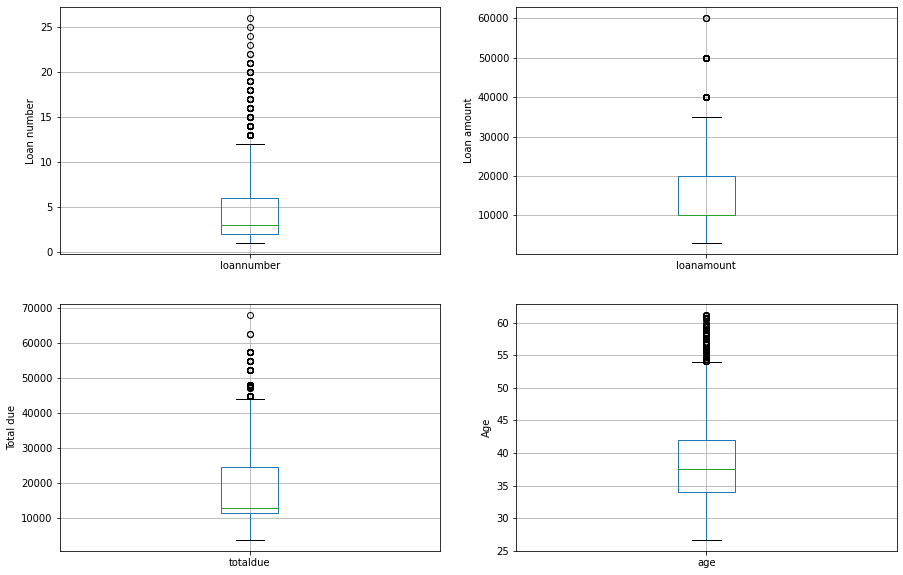

In [291]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
fig = numColumns.boxplot(column='loannumber')
fig.set_ylabel('Loan number')

plt.subplot(2,2,2)
fig = numColumns.boxplot(column='loanamount')
fig.set_ylabel('Loan amount')

plt.subplot(2,2,3)
fig = numColumns.boxplot(column='totaldue')
fig.set_ylabel('Total due')

plt.subplot(2,2,4)
fig = numColumns.boxplot(column='age')
fig.set_ylabel('Age')

Text(0, 0.5, 'Longitude')

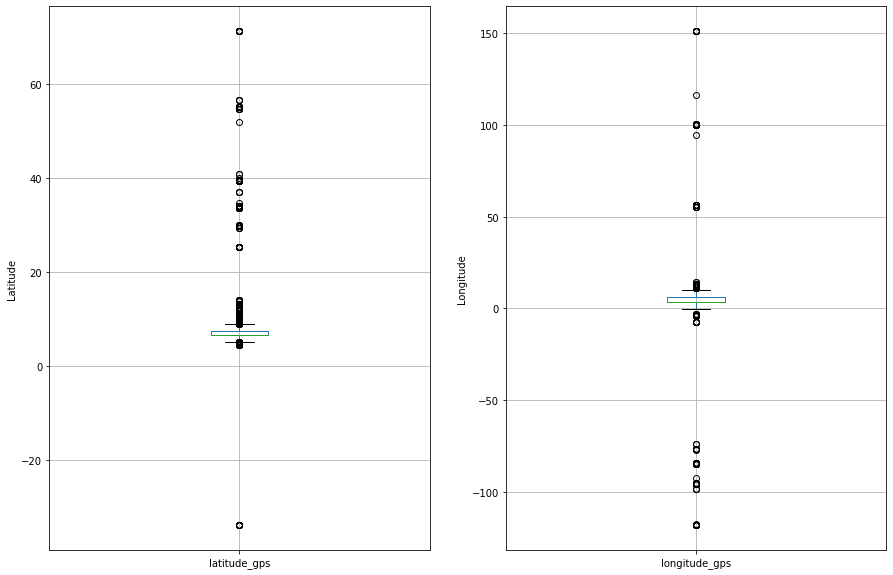

In [292]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
fig = numColumns.boxplot(column='latitude_gps')
fig.set_ylabel('Latitude')

plt.subplot(1,2,2)
fig = numColumns.boxplot(column='longitude_gps')
fig.set_ylabel('Longitude')



For our numerical columns, we can see that there are outliers in each column. These will not be removed though as these outliers could help the model better predict which loans may result in bad or good loans.

The outliers via longitude and latitude may be atttibuted to people who are outside Nigeria.

##### splitting data into target and feature

In [293]:
#creating a dataframe consisting of all of the columns that are going to be used to train 
#our models
newdf = pd.concat([numColumns, 
                  pd.get_dummies(previousCustomers.bank_account_type),
                  pd.get_dummies(previousCustomers.bank_name_clients),
                  pd.get_dummies(previousCustomers.employment_status_clients),
                  pd.get_dummies(previousCustomers.level_of_education_clients)], axis=1)

newdf

,loannumber,loanamount,totaldue,termdays,perf_loannumber,perf_loanamount,perf_totaldue,perf_termdays,longitude_gps,latitude_gps,...,Permanent,Retired,Self-Employed,Student,Unemployed,Education_not-given,Graduate,Post-Graduate,Primary,Secondary
0,2,10000.0,13000.0,30,12,30000.0,34500.0,30,3.432010,6.433055,...,1,0,0,0,0,0,0,1,0,0
1,9,10000.0,13000.0,30,12,30000.0,34500.0,30,3.432010,6.433055,...,1,0,0,0,0,0,0,1,0,0
2,8,20000.0,23800.0,30,12,30000.0,34500.0,30,3.432010,6.433055,...,1,0,0,0,0,0,0,1,0,0
3,10,20000.0,24500.0,30,12,30000.0,34500.0,30,3.432010,6.433055,...,1,0,0,0,0,0,0,1,0,0
4,11,20000.0,24500.0,30,12,30000.0,34500.0,30,3.432010,6.433055,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13668,1,10000.0,11500.0,15,2,10000.0,11500.0,15,5.252457,12.991440,...,1,0,0,0,0,1,0,0,0,0
13669,1,10000.0,13000.0,30,2,10000.0,13000.0,30,7.478858,9.055714,...,1,0,0,0,0,1,0,0,0,0
13670,1,10000.0,11500.0,15,2,10000.0,11500.0,15,3.381677,6.455923,...,1,0,0,0,0,1,0,0,0,0
13671,1,10000.0,11500.0,15,2,10000.0,13000.0,30,6.979660,4.879515,...,0,0,0,0,1,0,1,0,0,0


In [294]:
newdf.columns

Index(['loannumber', 'loanamount', 'totaldue', 'termdays', 'perf_loannumber',
       'perf_loanamount', 'perf_totaldue', 'perf_termdays', 'longitude_gps',
       'latitude_gps', 'age', 'loanlife', 'good_bad_flag', 'LateFirstPay',
       'EarlyFirstPay', 'Current', 'Other', 'Savings', 'Access Bank',
       'Diamond Bank', 'EcoBank', 'FCMB', 'Fidelity Bank', 'First Bank',
       'GT Bank', 'Heritage Bank', 'Keystone Bank', 'Skye Bank',
       'Stanbic IBTC', 'Standard Chartered', 'Sterling Bank', 'UBA',
       'Union Bank', 'Unity Bank', 'Wema Bank', 'Zenith Bank', 'Contract',
       'Employment_not-given', 'Permanent', 'Retired', 'Self-Employed',
       'Student', 'Unemployed', 'Education_not-given', 'Graduate',
       'Post-Graduate', 'Primary', 'Secondary'],
      dtype='object')

In [295]:
#separating the input features, X and the target feature, y that we want to predict
X = newdf.drop(['good_bad_flag'], axis=1)
y = newdf['good_bad_flag']

In [296]:
#Giving ourselves a test set of 20% of the initial records
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 4)

In [297]:
#Looking at the shape of our training and testing data
#Training data has 10,938 entries and the testing data has 2,735 entries
X_train.shape, X_test.shape

((10938, 47), (2735, 47))

In [298]:
X_train.columns

Index(['loannumber', 'loanamount', 'totaldue', 'termdays', 'perf_loannumber',
       'perf_loanamount', 'perf_totaldue', 'perf_termdays', 'longitude_gps',
       'latitude_gps', 'age', 'loanlife', 'LateFirstPay', 'EarlyFirstPay',
       'Current', 'Other', 'Savings', 'Access Bank', 'Diamond Bank', 'EcoBank',
       'FCMB', 'Fidelity Bank', 'First Bank', 'GT Bank', 'Heritage Bank',
       'Keystone Bank', 'Skye Bank', 'Stanbic IBTC', 'Standard Chartered',
       'Sterling Bank', 'UBA', 'Union Bank', 'Unity Bank', 'Wema Bank',
       'Zenith Bank', 'Contract', 'Employment_not-given', 'Permanent',
       'Retired', 'Self-Employed', 'Student', 'Unemployed',
       'Education_not-given', 'Graduate', 'Post-Graduate', 'Primary',
       'Secondary'],
      dtype='object')

In [299]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10938 entries, 2894 to 1146
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loannumber            10938 non-null  int64  
 1   loanamount            10938 non-null  float64
 2   totaldue              10938 non-null  float64
 3   termdays              10938 non-null  int64  
 4   perf_loannumber       10938 non-null  int64  
 5   perf_loanamount       10938 non-null  float64
 6   perf_totaldue         10938 non-null  float64
 7   perf_termdays         10938 non-null  int64  
 8   longitude_gps         10938 non-null  float64
 9   latitude_gps          10938 non-null  float64
 10  age                   10938 non-null  float64
 11  loanlife              10938 non-null  float64
 12  LateFirstPay          10938 non-null  float64
 13  EarlyFirstPay         10938 non-null  float64
 14  Current               10938 non-null  uint8  
 15  Other            

In [300]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2735 entries, 5339 to 12030
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loannumber            2735 non-null   int64  
 1   loanamount            2735 non-null   float64
 2   totaldue              2735 non-null   float64
 3   termdays              2735 non-null   int64  
 4   perf_loannumber       2735 non-null   int64  
 5   perf_loanamount       2735 non-null   float64
 6   perf_totaldue         2735 non-null   float64
 7   perf_termdays         2735 non-null   int64  
 8   longitude_gps         2735 non-null   float64
 9   latitude_gps          2735 non-null   float64
 10  age                   2735 non-null   float64
 11  loanlife              2735 non-null   float64
 12  LateFirstPay          2735 non-null   float64
 13  EarlyFirstPay         2735 non-null   float64
 14  Current               2735 non-null   uint8  
 15  Other            

No missing values in the training and testing data

##### Scaling of the data

In [301]:
cols = X_train.columns

In [302]:
#Going to use a standard scaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In the next section, we are going to be building our model.
From earlier in our notebook, we noticed that our data was imbalanced with the number of bad loans much smaller than the number of good loans. This doesn't give our models enough data to learn from about what a bad loan could look like.

We are going to deal with the imbalanced data but first, we want to see what would happen if we trained our data with the imbalanced dataset.

## Logistic Regression
### with imbalanced data

The first model we are building is a logistic regression model and it is dealing with the imbalanced data.

In [303]:
#Building our logistic regression model
logreg = LogisticRegression(solver='liblinear', random_state=0)

logreg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [304]:
#Providing our testing data for predictions
y_pred_test = logreg.predict(X_test)

In [305]:
#looking at the predictions given by the model
y_pred_test

array(['Good', 'Good', 'Good', ..., 'Good', 'Good', 'Good'], dtype=object)

In [306]:
print('Model accuracy score(test): ', accuracy_score(y_test, y_pred_test))

Model accuracy score(test):  0.83327239488117


In [307]:
y_pred_train = logreg.predict(X_train)

print('Model accuracy score(train): ', accuracy_score(y_train, y_pred_train))

Model accuracy score(train):  0.811848601206802


From the two cells above, we can see that the model's accuracy seems to be very high. This seems very strange considering we have imbalanced data

In [308]:
y_test.value_counts()

Good    2275
Bad      460
Name: good_bad_flag, dtype: int64

In [309]:
#confusion matrix for our model
cm =confusion_matrix(y_test, y_pred_test)

In [310]:
cm

array([[  11,  449],
       [   7, 2268]])

In [311]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)

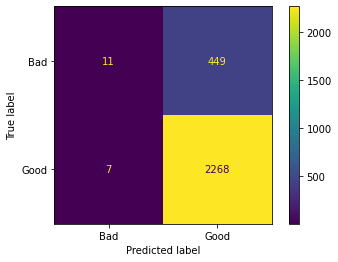

In [312]:
disp.plot()

From the confusion matrix above, we can see that the model is predicting good loans correctly: 2268 good loans were correctly precdicted with only 7 missclassified.

We can also see that it is only accurately predicted only 11 bad loans as bad. 449 bad loans were wrongly classified as good loans. 
This can be attributed to the fact that the model has a lot of data on good loans but not enough on bad loans.

In [313]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         Bad       0.61      0.02      0.05       460
        Good       0.83      1.00      0.91      2275

    accuracy                           0.83      2735
   macro avg       0.72      0.51      0.48      2735
weighted avg       0.80      0.83      0.76      2735



From the classification report above, we can still see the model doing very well on the good loans but very poorly for the bad loans
We see we only have 460 instances of bad loans to train on. 
The macro average is low also show that data is imbalanced.

##### Dealing with imbalanced data
Now that we've seen the effect of imbalanced data, we can deal with this by creating new data from the existing data that we can then use to train our model.

In [314]:
X = newdf.drop(['good_bad_flag'], axis=1)
y = newdf['good_bad_flag']

In [315]:
#SMOTE is an oversampling technique that creates new data from existing 
#for the minority class in this case, bad loans
#the sampling strategy chosen is 
smote_algo = SMOTE(sampling_strategy='all',random_state=0)
smote_data_X, smote_data_Y = smote_algo.fit_resample(X,y)
smote_data_X = pd.DataFrame(data=smote_data_X, columns=X.columns)
smote_data_Y = pd.DataFrame(data=smote_data_Y, columns=['good_bad_flag'])


In [316]:
smote_data = smote_data_X
smote_data['good_bad_flag'] = smote_data_Y['good_bad_flag']

In [317]:
smote_data.drop_duplicates(keep="first", inplace=True) #removing duplicate data if any
smote_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22292 entries, 0 to 22291
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loannumber            22292 non-null  int64  
 1   loanamount            22292 non-null  float64
 2   totaldue              22292 non-null  float64
 3   termdays              22292 non-null  int64  
 4   perf_loannumber       22292 non-null  int64  
 5   perf_loanamount       22292 non-null  float64
 6   perf_totaldue         22292 non-null  float64
 7   perf_termdays         22292 non-null  int64  
 8   longitude_gps         22292 non-null  float64
 9   latitude_gps          22292 non-null  float64
 10  age                   22292 non-null  float64
 11  loanlife              22292 non-null  float64
 12  LateFirstPay          22292 non-null  float64
 13  EarlyFirstPay         22292 non-null  float64
 14  Current               22292 non-null  uint8  
 15  Other              

After applying SMOTE, we now have over 20,000 entries as compared to the 10,000 we had originally trained with for the first model instance.
Now we can go ahead and train a new model using this more balanced data.

In [318]:
X = smote_data.drop(['good_bad_flag'],axis=1)
y = smote_data['good_bad_flag']

In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 2)

In [320]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [321]:
X_train.shape, X_test.shape

((17833, 47), (4459, 47))

In [322]:
logreg = LogisticRegression(solver='liblinear', random_state=3)

In [323]:
logreg.fit(X_train, y_train)

LogisticRegression(random_state=3, solver='liblinear')

In [324]:
y_pred_test = logreg.predict(X_test)
y_pred_test

array(['Good', 'Bad', 'Good', ..., 'Bad', 'Bad', 'Good'], dtype=object)

In [325]:
print('Model accuracy score(test): ', accuracy_score(y_test, y_pred_test))

Model accuracy score(test):  0.8174478582641848


In [326]:
y_pred_train = logreg.predict(X_train)

print('Model accuracy score(train): ', accuracy_score(y_train, y_pred_train))

Model accuracy score(train):  0.8083889418493804


In [327]:
y_test.value_counts()

Bad     2245
Good    2214
Name: good_bad_flag, dtype: int64

In [328]:
null_accuracy = 1831/(len(y_test))

In [329]:
null_accuracy

0.4106301861403902

In [330]:
cm =confusion_matrix(y_test, y_pred_test)

In [331]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)

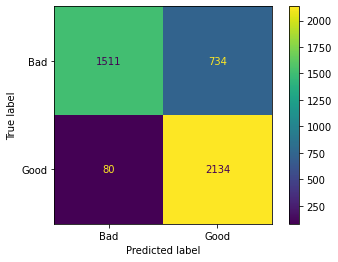

In [332]:
disp.plot()

From the matrix above, we can see that with this balance data set, the model was able to correctly predict 1513 bad loans. Although this is better than our initial model, the model still misclassified 732 bad loans as good.

The performance of the model at predicting good loans is still high.

In [333]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         Bad       0.95      0.67      0.79      2245
        Good       0.74      0.96      0.84      2214

    accuracy                           0.82      4459
   macro avg       0.85      0.82      0.81      4459
weighted avg       0.85      0.82      0.81      4459



Since our data is now balanced, we can see the macro average increased as well.

We can see the model is performing a little better, not yet best, at predicting bad loans.
We can adjust the thresholds to help it perform better.

In [334]:
#getting the bad and good loan probabilities for each of our testing data
y_pred_prob = logreg.predict_proba(X_test)
y_pred_prob

array([[2.88269490e-01, 7.11730510e-01],
       [9.84946622e-01, 1.50533781e-02],
       [4.66563751e-01, 5.33436249e-01],
       ...,
       [9.99956054e-01, 4.39461576e-05],
       [6.59709536e-01, 3.40290464e-01],
       [1.16670494e-01, 8.83329506e-01]])

In [335]:
#storing the probabilities in a dataframe
y_pred_prob_df = pd.DataFrame(data=y_pred_prob, columns=['Probability of Good loan (0)',
                                                         'Probability of Bad loan (1)'])

y_pred_prob_df

,Probability of Good loan (0),Probability of Bad loan (1)
0,0.288269,0.711731
1,0.984947,0.015053
2,0.466564,0.533436
3,0.376510,0.623490
4,0.369785,0.630215
...,...,...
4454,0.198893,0.801107
4455,0.996345,0.003655
4456,0.999956,0.000044
4457,0.659710,0.340290


In [336]:
y_pred1 = logreg.predict_proba(X_test)[:,1]
y_pred0 = logreg.predict_proba(X_test)[:,0]

In [337]:
y_pred1.shape

(4459,)

In [338]:
#plot ROC curve

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred1, pos_label='Good')

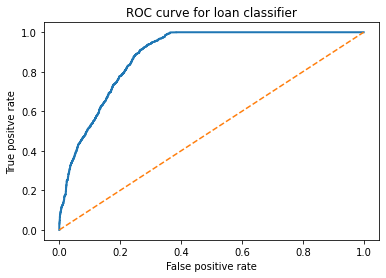

In [339]:
plt.figure(figsize = (6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], '--')
plt.title('ROC curve for loan classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positve rate')
plt.show()

In [340]:
#computing AUC 

from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_test, y_pred1)

print(ROC_AUC)

0.884595698963671


In [341]:
thresholds

array([1.99987743e+00, 9.99877431e-01, 9.53330134e-01, ...,
       1.70407955e-02, 1.64848553e-02, 2.95486298e-11])

In [342]:
#y_pred1 = logreg.predict_proba(X_test)[:,1]
y_pred_prob= y_pred1.reshape(1,-1)

In [343]:
y_pred_prob

array([[7.11730510e-01, 1.50533781e-02, 5.33436249e-01, ...,
        4.39461576e-05, 3.40290464e-01, 8.83329506e-01]])

In [344]:
y_pred_prob.shape

(1, 4459)

Tuning the threshold to improve model performance. The threshold can changed multiple times to see if the performance of the logistic model's prediction will improve. 

In [345]:
y_pred_class = binarize(y_pred_prob, threshold=1.99987700e+00)[0]
y_pred_class

array([0., 0., 0., ..., 0., 0., 0.])

In [346]:
y_test

3092     Good
17257     Bad
10882    Good
9413     Good
11331    Good
         ... 
3321     Good
15499     Bad
17287     Bad
473       Bad
7265     Good
Name: good_bad_flag, Length: 4459, dtype: object

In [347]:
y_test1 = y_test.apply(lambda x: 0 if x <= 'Good' else 1)

In [348]:
cm =confusion_matrix(y_test1, y_pred_class)
cm

array([[4459]])

### K-nearest neighbours

In [349]:
#we're going to build three models testing out a different number of nearest neighbours to 
#see which number is best performing

#model where n_neighbors = 10
knnr = KNeighborsClassifier(n_neighbors = 2 , metric='minkowski',p=2)


In [350]:
knnr.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [351]:
y_pred = knnr.predict(X_test)

In [352]:
accuracy_score= accuracy_score(y_test, y_pred)
accuracy_score

0.902220228750841

In [353]:
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[2168,   77],
       [ 359, 1855]])

In [354]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         Bad       0.86      0.97      0.91      2245
        Good       0.96      0.84      0.89      2214

    accuracy                           0.90      4459
   macro avg       0.91      0.90      0.90      4459
weighted avg       0.91      0.90      0.90      4459



For n_neighbours=10, we can see the model is performing really well predicting the loan classes.
In the next cell we have accuracies and classification reports for n_neighbours=15, 20, 5,3

#### n_neighbours = 15

|  | precision | recall | f1-score | support
| :- | -: | :-: |:-: |:-: |
| Bad | 0.88 | 0.86 | 0.87 | 2245
| Good | 0.87 | 0.88 | 0.87 | 2214
| accuracy | |  | 0.87 | 4459
| macro avg |0.87 | 0.87 | 0.87 | 4459
| weighted avg |0.87 | 0.87 | 0.87 | 4459

#### n_neighbours = 20

|  | precision | recall | f1-score | support
| :- | -: | :-: |:-: |:-: |
| Bad | 0.87 | 0.86 | 0.86 | 2245
| Good | 0.86 | 0.87 | 0.86 | 2214
| accuracy | |  | 0.86 | 4459
| macro avg |0.86 | 0.86 | 0.86 | 4459
| weighted avg |0.86 | 0.86 | 0.86 | 4459

#### n_neighbours = 5

|  | precision | recall | f1-score | support
| :- | -: | :-: |:-: |:-: |
| Bad | 0.90 | 0.92 | 0.91 | 2245
| Good | 0.92 | 0.90 | 0.91 | 2214
| accuracy | |  | 0.91 | 4459
| macro avg |0.91 | 0.91 | 0.91 | 4459
| weighted avg |0.91 | 0.91 | 0.91 | 4459

#### n_neighbours = 3

|  | precision | recall | f1-score | support
| :- | -: | :-: |:-: |:-: |
| Bad | 0.91 | 0.94 | 0.92 | 2245
| Good | 0.93 | 0.91 | 0.92 | 2214
| accuracy | |  | 0.92 | 4459
| macro avg |0.92 | 0.92 | 0.92 | 4459
| weighted avg |0.92 | 0.92 | 0.92 | 4459

From the reports and accuracies above, we can see that n_neighbours=3 yields the best results for our loan classifier for both identifiying the good and bad loans.

Let us see if n_neighbours = 2 will yield even better results

#### n_neighbours = 2

|  | precision | recall | f1-score | support
| :- | -: | :-: |:-: |:-: |
| Bad | 0.86| 0.97 | 0.91 | 2245
| Good | 0.96 | 0.84 | 0.89 | 2214
| accuracy | |  | 0.90 | 4459
| macro avg |0.91 | 0.90 | 0.90 | 4459
| weighted avg |0.91 | 0.90 | 0.90 | 4459

n_neighbours =2 doesn't give better results and so we shall take n_neighbours=3

#### Support vector machines

In [355]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)

In [356]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [357]:
classifier = SVC(kernel='linear', random_state=0)

In [358]:
classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=0)

In [359]:
y_pred= classifier.predict(X_test)
y_pred

array(['Good', 'Bad', 'Good', ..., 'Good', 'Good', 'Good'], dtype=object)

In [360]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         Bad       1.00      0.63      0.77      2222
        Good       0.73      1.00      0.84      2237

    accuracy                           0.81      4459
   macro avg       0.86      0.81      0.81      4459
weighted avg       0.86      0.81      0.81      4459



### Of the three models, KNN with n_neighbours=3 seems to be performing the best and that is what we would provide as a loan classifier.
